In [ ]:
#1.1

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def plot_images_and_histograms(image_name):
    image_color = cv2.imread(image_name)
    image_rgb = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    #  Otsu  threshold
    thresh_val = threshold_otsu(image_gray)
    binary = image_gray > thresh_val

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f"Segmentation for {image_name}", fontsize=16)

    # colorful
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title("Original (Color)")
    axes[0, 0].axis("off")

    # grey
    axes[0, 1].imshow(image_gray, cmap='gray')
    axes[0, 1].set_title("Grayscale")
    axes[0, 1].axis("off")

    # segmentation
    axes[0, 2].imshow(binary, cmap='gray')
    axes[0, 2].set_title(f"Otsu Thresholding\nThreshold = {thresh_val:.2f}")
    axes[0, 2].axis("off")

    # grey
    axes[1, 0].hist(image_gray.ravel(), bins=256)
    axes[1, 0].axvline(thresh_val, color='red', linestyle='--')
    axes[1, 0].set_title("Grayscale Histogram")
    axes[1, 0].set_xlabel("Pixel Intensity")
    axes[1, 0].set_ylabel("Frequency")

    axes[1, 1].axis("off")
    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    return thresh_val


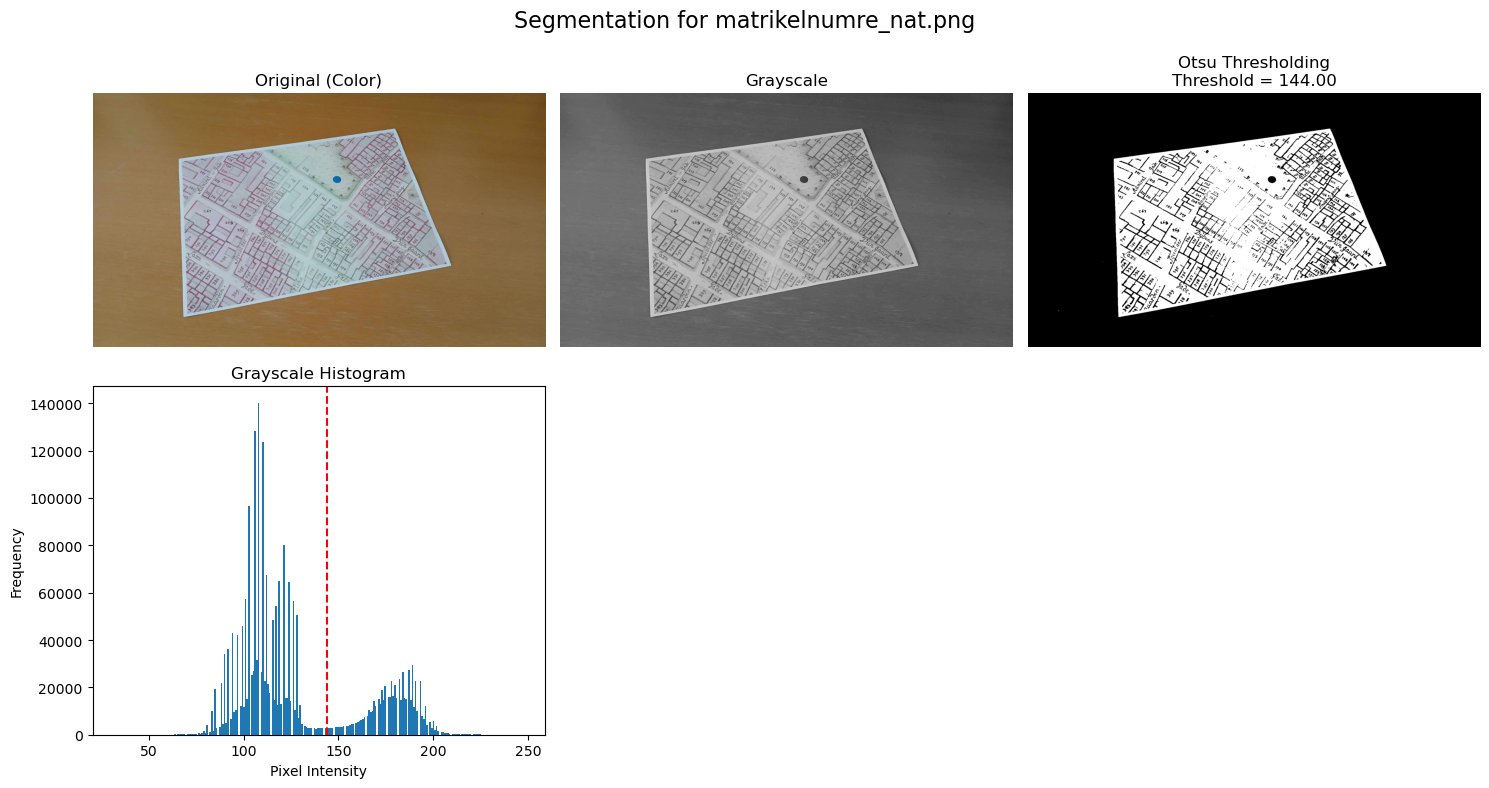

In [5]:
thresh_nat = plot_images_and_histograms("matrikelnumre_nat.png")


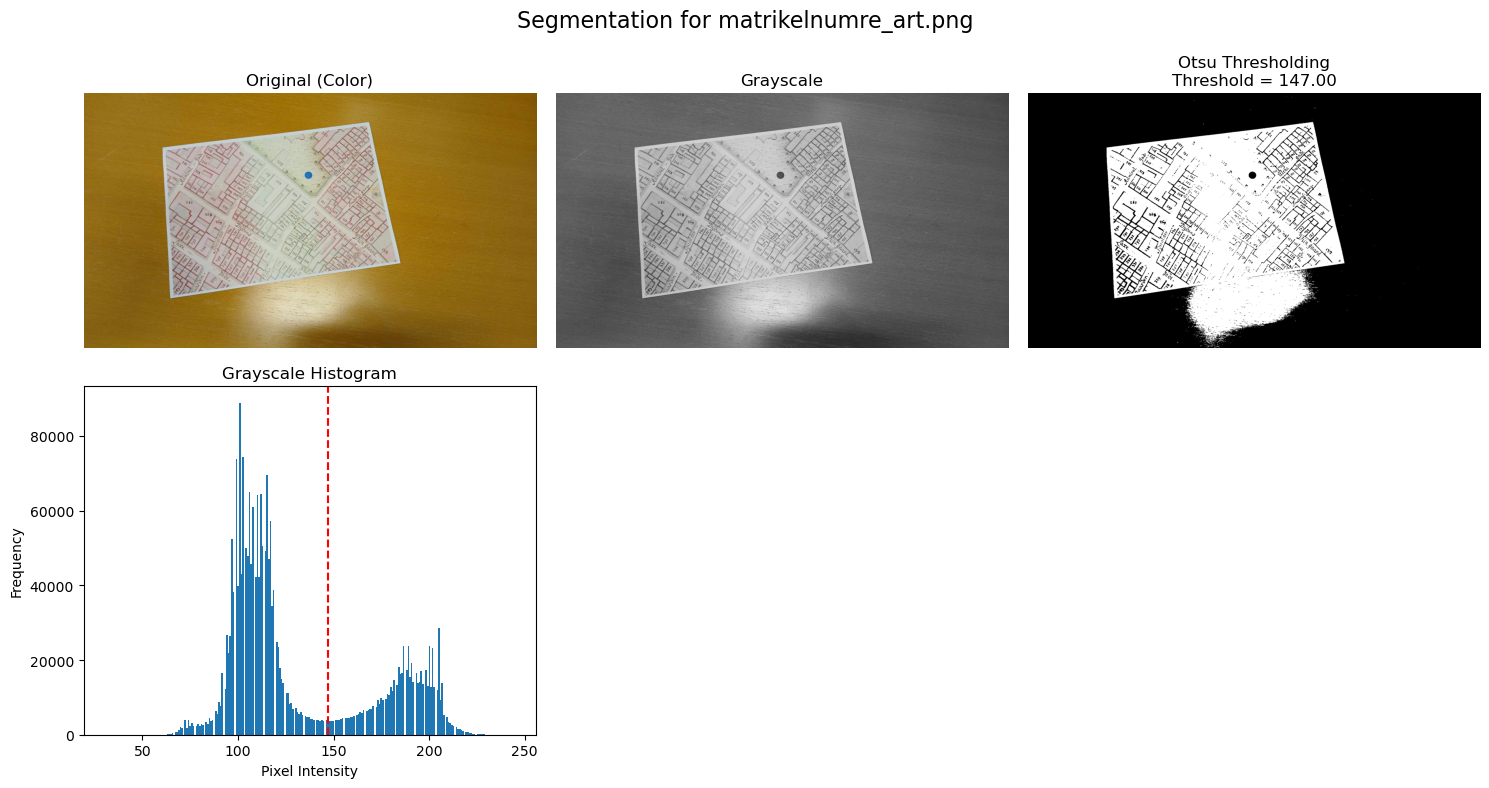

In [6]:
thresh_art = plot_images_and_histograms("matrikelnumre_art.png")

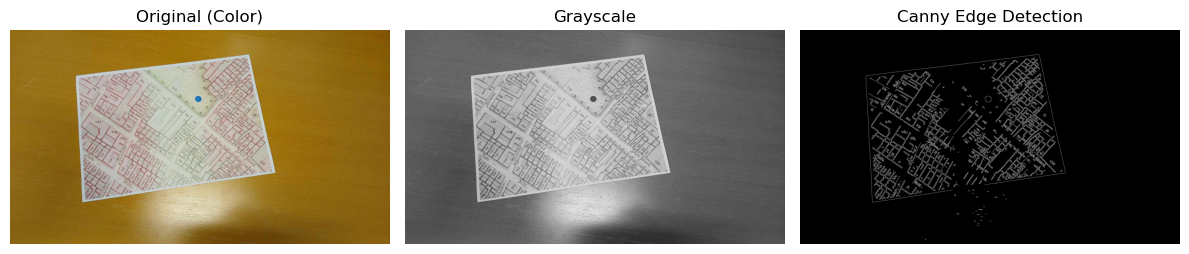

In [7]:
#1.2
image_path = "matrikelnumre_art.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image_blur = cv2.GaussianBlur(image_gray, (5, 5), 1.0)

edges = cv2.Canny(image_blur, threshold1=100, threshold2=200)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original (Color)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

plt.tight_layout()
plt.show()


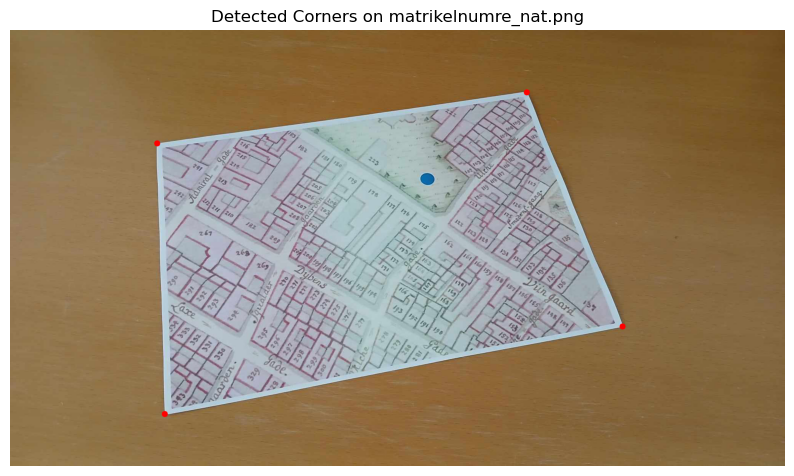

Detected 4 corners (x, y):
(1360, 166)
(387, 300)
(407, 1011)
(1612, 781)


In [9]:
image_path = "matrikelnumre_nat.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Preprocessing: blur + threshold to suppress inner map textures
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
_, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)

#further denoising using morphological opening
kernel = np.ones((5, 5), np.uint8)
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Harris corner detection
gray_float = np.float32(opened)
dst = cv2.cornerHarris(gray_float, blockSize=2, ksize=3, k=0.04)

# Dilate corner response to enhance visibility
dst_dilated = cv2.dilate(dst, None)

# Extract corner coordinates using a threshold
corner_threshold = 0.01 * dst_dilated.max()
corner_coords = np.argwhere(dst_dilated > corner_threshold)
corner_coords = np.flip(corner_coords, axis=1)  # Convert to (x, y)

# Find the largest external contour (assumed to be the map border)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
epsilon = 0.05 * cv2.arcLength(largest_contour, True)
approx_corners = cv2.approxPolyDP(largest_contour, epsilon, True)

# Extract the four corner points
four_corners = [tuple(pt[0]) for pt in approx_corners]

# Draw the detected corners on the image
image_draw = image.copy()
for x, y in four_corners:
    cv2.circle(image_draw, (x, y), radius=8, color=(0, 0, 255), thickness=-1)

# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))
plt.title("Detected Corners on matrikelnumre_nat.png")
plt.axis("off")
plt.show()

# Print the detected corner coordinates
print("Detected 4 corners (x, y):")
for pt in four_corners:
    print(pt)


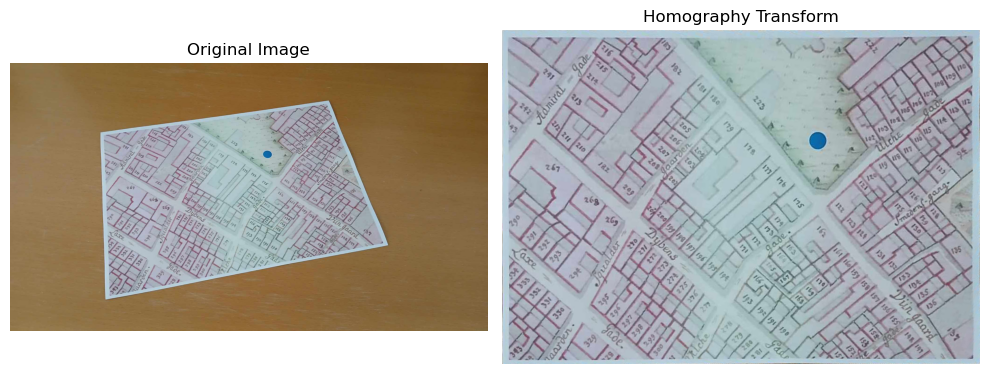

In [11]:
#2.2
image = cv2.imread("matrikelnumre_nat.png")

pts_src = np.array([
    [387, 300],     # top-left
    [1360, 166],    # top-right
    [1612, 781],    # bottom-right
    [407, 1011]     # bottom-left
], dtype=np.float32)

width = 1000
height = 700
pts_dst = np.array([
    [0, 0],                 # top-left
    [width - 1, 0],         # top-right
    [width - 1, height - 1],# bottom-right
    [0, height - 1]         # bottom-left
], dtype=np.float32)

H = cv2.getPerspectiveTransform(pts_src, pts_dst)

warped = cv2.warpPerspective(image, H, (width, height))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Homography Transform")
plt.axis("off")

plt.tight_layout()
plt.show()
